In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Libraries, data, and functions

In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import pandas as pd
import mpl_toolkits.mplot3d as plt3d
matplotlib.rcParams.update({'font.size': 22})

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,Reshape, Dropout, Activation, Flatten, Conv1D, MaxPooling1D, UpSampling1D, Input
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split

In [8]:
# Build
def get_model(latent_dim):
  input_img = Input(shape=(9,))
  l1      = Dense(        256, activation = tf.keras.layers.LeakyReLU() )(input_img)
  encoded = Dense( latent_dim, activation = tf.keras.layers.LeakyReLU() )(l1)
  l2      = Dense(        256, activation = tf.keras.layers.LeakyReLU() )(encoded)
  decoded = Dense(          9, activation = 'linear'                    )(l2)
  return Model(input_img, decoded)

In [9]:
def loss_function(y_true, y_pred):

  bs = len(y_true)
  y_true, y_pred = tf.reshape(y_true, (bs,3,3)), tf.reshape(y_pred,(bs,3,3)) 

  perm_rows = tf.linalg.LinearOperatorPermutation([1,2,0])
  true_dist = tf.sqrt(tf.reduce_sum(tf.math.squared_difference( y_true, tf.matmul(perm_rows,y_true) ), axis=-1, keepdims=True))
  pred_dist = tf.sqrt(tf.reduce_sum(tf.math.squared_difference( y_pred, tf.matmul(perm_rows,y_pred) ), axis=-1, keepdims=True))

  return tf.reduce_sum( tf.abs( tf.math.subtract(true_dist, pred_dist) ) , axis = 1)  

In [10]:
#Function which plots the 3D traingle
minmax = (0,1)

def Plot_2(v1, v2, v3, vv1, vv2, vv3):
  fig = plt.figure()
  fig.set_size_inches(5,5)
  ax = fig.add_subplot(111, projection='3d')
  
  X = np.array([v1,v2,v3])
  Y = np.array([vv1,vv2,vv3])
  
  l0x, ll0x = np.linspace(v1[0], v2[0], 50), np.linspace(vv1[0], vv2[0], 50)
  l1x, ll1x = np.linspace(v2[0], v3[0], 50), np.linspace(vv2[0], vv3[0], 50)
  l2x, ll2x = np.linspace(v3[0], v1[0], 50), np.linspace(vv3[0], vv1[0], 50)
  l0y, ll0y = np.linspace(v1[1], v2[1], 50), np.linspace(vv1[1], vv2[1], 50)
  l1y, ll1y = np.linspace(v2[1], v3[1], 50), np.linspace(vv2[1], vv3[1], 50)
  l2y, ll2y = np.linspace(v3[1], v1[1], 50), np.linspace(vv3[1], vv1[1], 50)
  l0z, ll0z = np.linspace(v1[2], v2[2], 50), np.linspace(vv1[2], vv2[2], 50)
  l1z, ll1z = np.linspace(v2[2], v3[2], 50), np.linspace(vv2[2], vv3[2], 50)
  l2z, ll2z = np.linspace(v3[2], v1[2], 50), np.linspace(vv3[2], vv1[2], 50)

  #Drawing lines
  ax.scatter(l0x, l0y, l0z, color='red', marker='s', s = 1, alpha = 0.1), ax.scatter(ll0x, ll0y, ll0z, color='black', marker='s', s = 1, alpha = 0.1)
  ax.scatter(l1x, l1y, l1z, color='red', marker='s', s = 1, alpha = 0.1), ax.scatter(ll1x, ll1y, ll1z, color='black', marker='s', s = 1, alpha = 0.1)
  ax.scatter(l2x, l2y, l2z, color='red', marker='s', s = 1, alpha = 0.1), ax.scatter(ll2x, ll2y, ll2z, color='black', marker='s', s = 1, alpha = 0.1)


  #plot the nodes
  for x, y, z in X:
    ax.scatter(x, y, z, color='red', marker='o', s=30)
  for x, y, z in Y:
    ax.scatter(x, y, z, color='black', marker='o', s=30)

  ax.set_xlim(minmax)
  ax.set_ylim(minmax) 
  ax.set_zlim(minmax) 

In [11]:
def side_lens(v):
  vx,vy,vz = np.array_split(v , 3)
  return np.array([np.linalg.norm(vx-vy), 
                   np.linalg.norm(vy-vz), 
                   np.linalg.norm(vz-vx)])

This cell is for importing larger datasets from google drive instead of remaking them.

### Generating Data

In [12]:
def t():
  phi   = 2*np.pi*np.random.random()
  theta = np.pi*np.random.random()
  return np.array([np.sin(theta)*np.cos(phi),
                   np.sin(theta)*np.sin(phi),
                   np.cos(theta)])

In [13]:
DATA_SIZE = 10000
side      =  .5    # Scaling for 
r_min     = 0.48   # Need a minimum as in nature the pole at r = 0 is non-phyiscal
l         = r_min+0.2

In [14]:
# creating a dataset of triangles with a minimum side lenght r_min

side_lenghts = np.zeros( (DATA_SIZE, 3, ))
euc_data     = np.zeros( (DATA_SIZE, 9, ))

for i in range(DATA_SIZE):

  # Randomly selecting 2 points seperated by l
  v1= np.random.random( (3,) )
  TRUTH = True

  # Ensuring 2nd point is always in unit cube
  while TRUTH:
    v2 = v1 + l*t()
    if (np.all(0<v2)) and (np.all(v2<1)):
      TRUTH = False

  # ensuring minimum side lenght > r_min    
  col_vec = np.zeros(9)
  while( np.min(side_lens(col_vec)) <= r_min):
    v3      = np.random.random( (3,) )
    col_vec = np.concatenate((v1,v2,v3))
  

  euc_data[i]   = col_vec
  
  side_lenghts[i]  = side_lens(euc_data[i]) 

In [15]:
np.max(euc_data), np.min(euc_data),np.max(side_lenghts), np.min(side_lenghts)

(0.9999918376168156,
 1.5505678161220615e-05,
 1.5079924012029622,
 0.4800023171218281)

In [16]:
print(np.random.permutation(side_lenghts))
psides = np.zeros_like(side_lenghts)

for i, sid in enumerate(side_lenghts):
  psides[i] = np.random.permutation(sid)

print(psides)


[[0.68       0.62641575 1.11779375]
 [0.68       0.68112212 0.48756892]
 [0.68       0.74099413 0.8522136 ]
 ...
 [0.68       0.74153052 0.73905205]
 [0.68       0.81428993 0.68387481]
 [0.68       1.11613622 1.02162595]]
[[1.17126633 0.68       0.81842673]
 [0.83934548 0.68       1.03340194]
 [1.01354372 0.98338595 0.68      ]
 ...
 [0.68       0.90879422 0.53708277]
 [0.71596214 0.68       0.97919701]
 [0.68       0.89836367 0.50419569]]


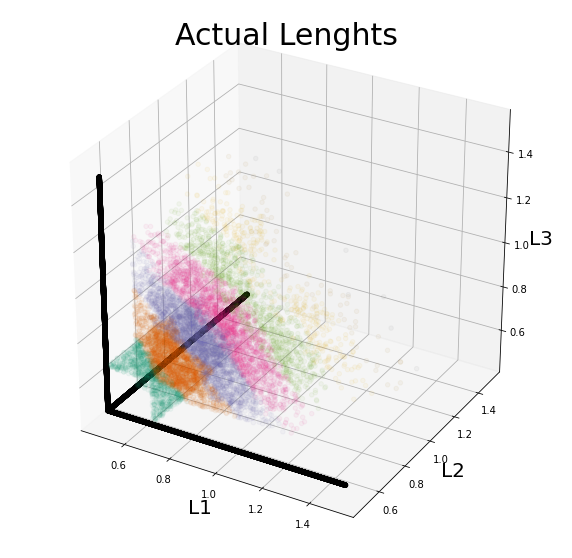

In [17]:
lens = psides


tot_lens  =  lens[:,0] +  lens[:,1] + lens[:,2]
from sklearn.preprocessing import MinMaxScaler

scaler_col = MinMaxScaler()
color_map = scaler_col.fit_transform(tot_lens.reshape( (DATA_SIZE,1) )) #normalize( tot_lens, np.min(tot_lens), np.max(tot_lens) )


fig = plt.figure( figsize = (10,10) );  
matplotlib.rc('font', size=20)
ax1 = fig.add_subplot(111,projection='3d')
ax1.scatter3D(lens[:,0],lens[:,1],lens[:,2], 
                  zdir = 'x', c=color_map,  cmap=plt.get_cmap('Dark2'),
                  alpha = 0.05, label = 'Node Value');

line1 = np.linspace(np.min(lens),np.max(lens),2000)
line2 = np.linspace(np.min(lens),np.min(lens),2000)

              
ax1.set_title('Actual Lenghts',fontsize = 30)

ax1.xaxis.set_tick_params(labelsize=10)
ax1.yaxis.set_tick_params(labelsize=10)
ax1.zaxis.set_tick_params(labelsize=10)
ax1.set_xlabel('L1');ax1.set_ylabel('L2');ax1.set_zlabel('L3');
ax1.scatter3D(line1,line2,line2, 
                  zdir = 'x', c='k',
                  alpha = 1);
ax1.scatter3D(line2,line1,line2, 
                  zdir = 'x', c='k',
                  alpha = 1);
ax1.scatter3D(line2,line2,line1, 
                  zdir = 'x', c='k',
                  alpha = 1);    
                  
plt.show()

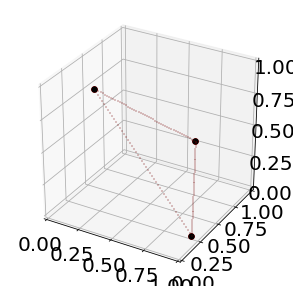

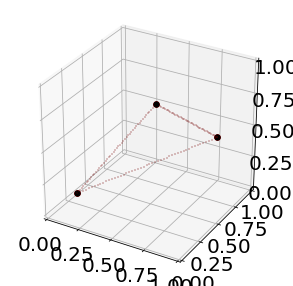

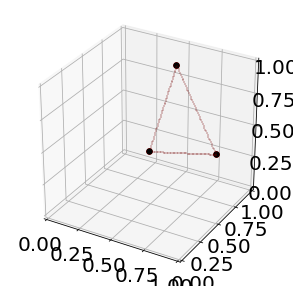

In [18]:
for i in range(3):
  vv1,vv2,vv3 = v1,v2,v3 = np.array_split(euc_data[i],3)

  Plot_2(v1,v2,v3,vv1,vv2,vv3)

In [19]:
df = pd.DataFrame()
df['x1'] = euc_data[:,0];   df['x2'] = euc_data[:,3];   df['x3'] = euc_data[:,6];
df['y1'] = euc_data[:,1];   df['y2'] = euc_data[:,4];   df['y3'] = euc_data[:,7];
df['z1'] = euc_data[:,2];   df['z2'] = euc_data[:,5];   df['z3'] = euc_data[:,8];

df['L1'] = side_lenghts[:,0]; df['L2'] = side_lenghts[:,1]; df['L3'] = side_lenghts[:,2];

In [20]:
df.to_csv('/content/drive/My Drive/Project/Autoencoder triangular molecule/training/Symm_data.csv')

## Loading and prepping data


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Project/Autoencoder triangular molecule/training/Symm_data.csv')

In [ ]:
# Euclidean data
x_data = np.array([df['x1'],df['y1'],df['z1'],
                   df['x2'],df['y2'],df['z2'],
                   df['x3'],df['y3'],df['z3'] ]).T
                   
# Side len data
x_data_sides  = np.array([df['L1'],
                          df['L2'],
                          df['L3']]).T

In [ ]:
x_data_sides - np.array([side_lens(i) for i in x_data])

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.11022302e-16,  0.00000000e+00,  1.11022302e-16],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00, -1.11022302e-16, -2.22044605e-16],
       [ 0.00000000e+00,  1.11022302e-16,  0.00000000e+00],
       [ 0.00000000e+00,  1.11022302e-16,  1.11022302e-16]])

In [ ]:
# Splitting the array into validation, training, and test sets

# Euclidean training x-data
x_train,  x_val = train_test_split(x_data , test_size = 0.1  , shuffle = False)
x_train, x_test = train_test_split(x_train, test_size = 1./9., shuffle = False)

## Training model

In [ ]:
# Build
def get_model(latent_dim):
  input_img = Input(shape=(9,))
  l1      = Dense(        256, activation = tf.keras.layers.LeakyReLU() )(input_img)
  encoded = Dense( latent_dim, activation = tf.keras.layers.LeakyReLU() )(l1)
  l2      = Dense(        256, activation = tf.keras.layers.LeakyReLU() )(encoded)
  decoded = Dense(          9, activation = 'linear'                    )(l2)
  return Model(input_img, decoded)

In [ ]:
# Compile and Train 
AE_2 = get_model(2)
AE_2.compile(optimizer=keras.optimizers.Adam(amsgrad=True), loss=loss_function)
history_2 = AE_2.fit(x_train, x_train,     # For autoencoders input data = target data
                    epochs=1000,
                    batch_size = 16,
                    validation_data=(x_val, x_val),
                    verbose = 2)

Epoch 1/1000
10000/10000 - 11s - loss: 0.1867 - val_loss: 0.1388
Epoch 2/1000
10000/10000 - 10s - loss: 0.1342 - val_loss: 0.1301
Epoch 3/1000
10000/10000 - 10s - loss: 0.1297 - val_loss: 0.1258
Epoch 4/1000
10000/10000 - 10s - loss: 0.1272 - val_loss: 0.1288
Epoch 5/1000
10000/10000 - 10s - loss: 0.1252 - val_loss: 0.1267
Epoch 6/1000
10000/10000 - 10s - loss: 0.1241 - val_loss: 0.1239
Epoch 7/1000
10000/10000 - 10s - loss: 0.1233 - val_loss: 0.1218
Epoch 8/1000
10000/10000 - 10s - loss: 0.1224 - val_loss: 0.1205
Epoch 9/1000
10000/10000 - 10s - loss: 0.1219 - val_loss: 0.1198
Epoch 10/1000
10000/10000 - 10s - loss: 0.1214 - val_loss: 0.1193
Epoch 11/1000
10000/10000 - 10s - loss: 0.1211 - val_loss: 0.1197
Epoch 12/1000
10000/10000 - 10s - loss: 0.1208 - val_loss: 0.1203
Epoch 13/1000
10000/10000 - 10s - loss: 0.1202 - val_loss: 0.1206
Epoch 14/1000
10000/10000 - 10s - loss: 0.1203 - val_loss: 0.1218
Epoch 15/1000
10000/10000 - 10s - loss: 0.1198 - val_loss: 0.1187
Epoch 16/1000
10000

In [ ]:
AE_2.evaluate(x_test,x_test)

625/625 [==============================] - 1s 1ms/step - loss: 0.0588


0.058751221746206284

In [ ]:
AE_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2560      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 514       
_________________________________________________________________
dense_6 (Dense)              (None, 256)               768       
_________________________________________________________________
dense_7 (Dense)              (None, 9)                 2313      
Total params: 6,155
Trainable params: 6,155
Non-trainable params: 0
_________________________________________________________________


In [ ]:
AE_2.save("/content/drive/MyDrive/Project/Custom_loss/Symm_AE2")
input   = AE_2.get_layer('input_2')
l1      = AE_2.get_layer('dense_4'  )
latent  = AE_2.get_layer('dense_5')
l2      = AE_2.get_layer('dense_6')
decode  = AE_2.get_layer('dense_7')

#Building encoder
encoder = Sequential()
encoder.add(input )
encoder.add(l1    )
encoder.add(latent)
encoder.summary()

#Building decoder
decoder = Sequential()
decoder.add(Flatten(input_shape=(2,)))
decoder.add(l2)
decoder.add(decode)
decoder.compile()
decoder.summary()

encoder.save("/content/drive/MyDrive/Project/Custom_loss/Symm_encoder2")
decoder.save("/content/drive/MyDrive/Project/Custom_loss/Symm_decoder2")


### Evaluating


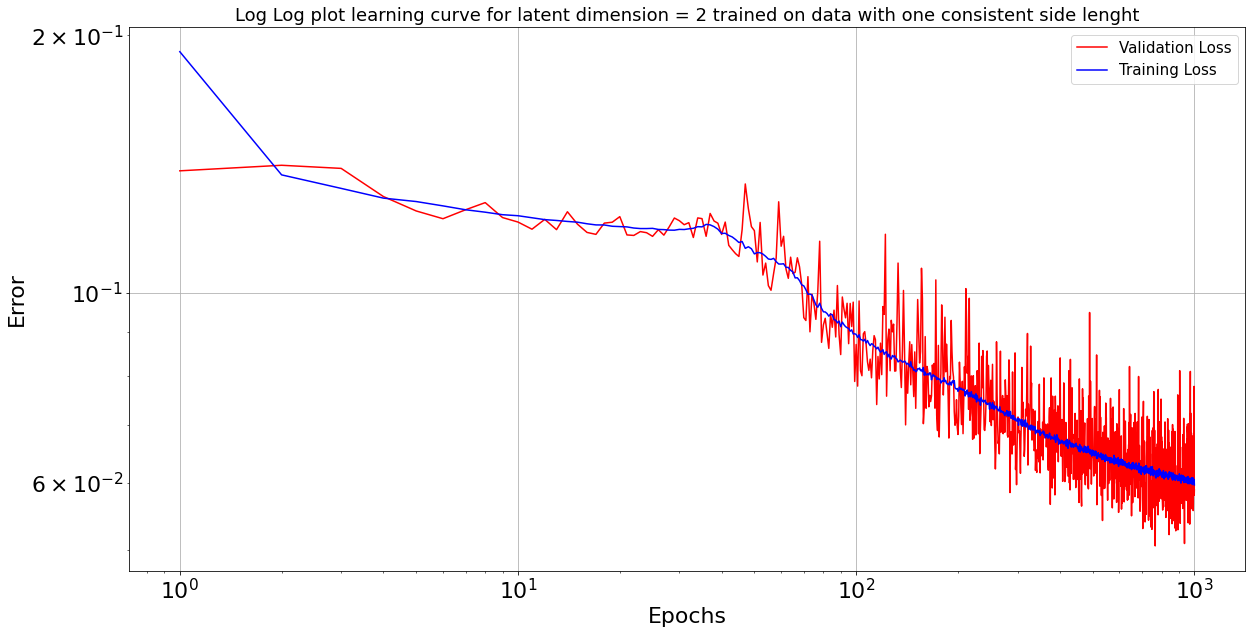

In [ ]:
# Plot Training Loss and Validation Loss

plt.figure(figsize=(20,10))
plt.loglog(range(1, len(history_2.history['val_loss'])+1,1), history_2.history['val_loss'], 'r',label='Validation Loss')
plt.loglog(range(1, len(history_2.history['loss'    ])+1,1), history_2.history['loss'    ], 'b',  label='Training Loss'  ) 
matplotlib.rc('font', size=15)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Log Log plot learning curve for latent dimension = 2 trained on data with one consistent side lenght')
plt.legend()
plt.grid()

In [ ]:
# Losses over a range of values of latent space size

historys = []
losses   = []
dims     = range(1,10)
epochs   = 100

for dim in dims:
  print('\n\n\n DIM = %d'%dim,'\n\n\n')

  model = get_model(dim)
  model.compile(optimizer=keras.optimizers.Adam(amsgrad=True), loss=loss_function)
  historys.append( model.fit(x_train, x_train,     # For autoencoders input data = target data
                         epochs=epochs,
                         validation_data=(x_val, x_val),
                         verbose = 1) )
  
  losses.append(model.evaluate(x = x_test, y = x_test))

5000/5000 [==============================] - 6s 1ms/step - loss: 0.1170 - val_loss: 0.1168
Epoch 39/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1160 - val_loss: 0.1247
Epoch 40/100
5000/5000 [==============================] - 7s 1ms/step - loss: 0.1158 - val_loss: 0.1100
Epoch 41/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1160 - val_loss: 0.1217
Epoch 42/100
5000/5000 [==============================] - 7s 1ms/step - loss: 0.1145 - val_loss: 0.1450
Epoch 43/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1145 - val_loss: 0.1117
Epoch 44/100
5000/5000 [==============================] - 7s 1ms/step - loss: 0.1133 - val_loss: 0.1080
Epoch 45/100
5000/5000 [==============================] - 7s 1ms/step - loss: 0.1141 - val_loss: 0.1155
Epoch 46/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1132 - val_loss: 0.1178
Epoch 47/100
5000/5000 [==============================] - 6s 1ms/step - loss:

In [ ]:
losses

[0.21332688629627228,
 0.08362874388694763,
 0.009974152781069279,
 0.02562817744910717,
 0.01121245976537466,
 0.01045855414122343,
 0.010910947807133198,
 0.009656667709350586,
 0.010858316905796528]

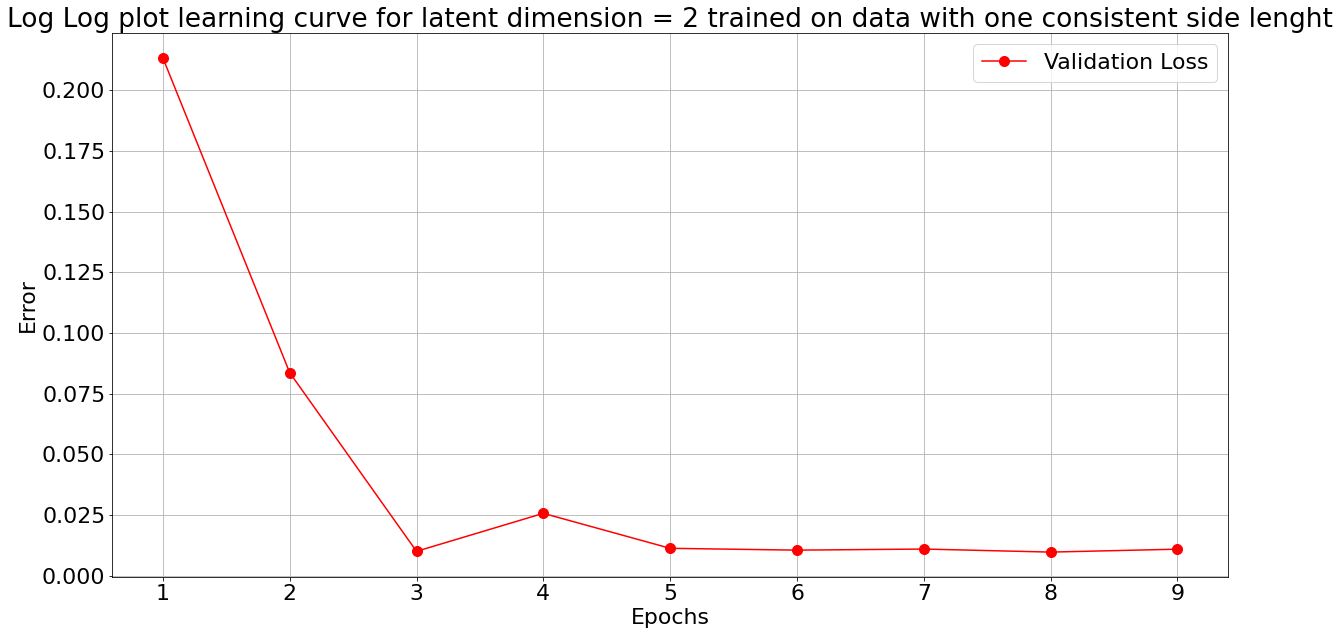

In [ ]:
# Plot Training Loss and Validation Loss

plt.figure(figsize=(20,10))
plt.plot(dims,losses, 'ro-', markersize = 10,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Log-Log learning curve for  trained on data with one consistent side lenght')
plt.legend()
plt.grid()

## Comparison with side lenght data

In [ ]:
# Losses over a range of values of latent space size

historys = []
losses   = []
dims     = range(1,10)
epochs   = 100

for dim in dims:
  print('\n\n\n DIM = %d'%dim,'\n\n\n')

  model = get_model(dim)
  model.compile(optimizer=keras.optimizers.Adam(amsgrad=True), loss=loss_function)
  historys.append( model.fit(x_train, x_train,     # For autoencoders input data = target data
                         epochs=epochs,
                         validation_data=(x_val, x_val),
                         verbose = 1) )
  
  losses.append(model.evaluate(x = x_test, y = x_test))

## Comparison with normal data without symmetry

### Generating Data

In [ ]:
def t():
  phi   = 2*np.pi*np.random.random()
  theta = np.pi*np.random.random()
  return np.array([np.sin(theta)*np.cos(phi),
                   np.sin(theta)*np.sin(phi),
                   np.cos(theta)])

In [ ]:
DATA_SIZE = 200000
side      =  .5    # Scaling for 
r_min     = 0.48   # Need a minimum as in nature the pole at r = 0 is non-phyiscal
l         = r_min+0.2

In [ ]:
# creating a dataset of triangles with a minimum side lenght r_min

side_lenghts = np.zeros( (DATA_SIZE, 3, ))
euc_data     = np.zeros( (DATA_SIZE, 9, ))

for i in range(DATA_SIZE):

  # ensuring minimum side lenght > r_min    
  col_vec = np.zeros(9)
  while( np.min(side_lens(col_vec)) <= r_min):
    v1 = np.random.random( (3,) )
    v2 = np.random.random( (3,) )
    v3 = np.random.random( (3,) )
    col_vec = np.concatenate((v1,v2,v3))
  euc_data[i]   = col_vec
  side_lenghts[i]  = side_lens(euc_data[i]) 

In [ ]:
np.max(euc_data), np.min(euc_data),np.max(side_lenghts), np.min(side_lenghts)

(0.999999598622004,
 1.4716599661124263e-07,
 1.579904698298682,
 0.4800006732940396)

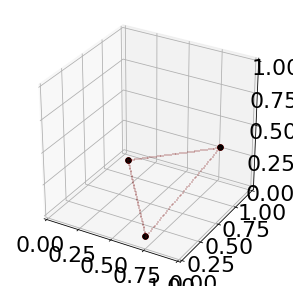

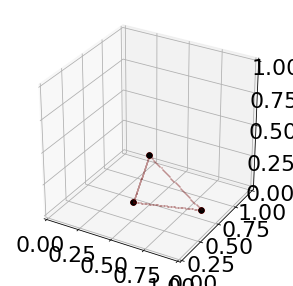

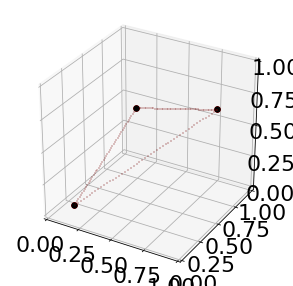

In [ ]:
for i in range(3):
  vv1,vv2,vv3 = v1,v2,v3 = np.array_split(euc_data[i],3)

  Plot_2(v1,v2,v3,vv1,vv2,vv3)

In [ ]:
df = pd.DataFrame()
df['x1'] = euc_data[:,0];   df['x2'] = euc_data[:,3];   df['x3'] = euc_data[:,6];
df['y1'] = euc_data[:,1];   df['y2'] = euc_data[:,4];   df['y3'] = euc_data[:,7];
df['z1'] = euc_data[:,2];   df['z2'] = euc_data[:,5];   df['z3'] = euc_data[:,8];

df['L1'] = side_lenghts[:,0]; df['L2'] = side_lenghts[:,1]; df['L3'] = side_lenghts[:,2];

In [ ]:
df.to_csv('/content/drive/My Drive/Project/Autoencoder triangular molecule/training/Symm_data_norm.csv')

In [ ]:
# Splitting the array into validation, training, and test sets

# Euclidean training x-data
x_train_norm,  x_val_norm = train_test_split(x_data_norm , test_size = 0.1  , shuffle = False)
x_train_norm, x_test_norm = train_test_split(x_train_norm, test_size = 1./9., shuffle = False)

In [ ]:
# Compile and Train 
AE_2_norm = get_model(2)
AE_2_norm.compile(optimizer=keras.optimizers.Adam(amsgrad=True), loss=loss_function)
history_2_norm = AE_2_norm.fit(x_train_norm, x_train_norm,     # For autoencoders input data = target data
                              epochs=1000,
                              validation_data=(x_val_norm, x_val_norm),
                              verbose = 2)
AE_2_norm.save("/content/drive/MyDrive/Project/Custom_loss/Symm_AE2_norm")

Epoch 1/1000
5000/5000 - 6s - loss: 0.2851 - val_loss: 0.2061
Epoch 2/1000
5000/5000 - 5s - loss: 0.2050 - val_loss: 0.2002
Epoch 3/1000
5000/5000 - 5s - loss: 0.1996 - val_loss: 0.1947
Epoch 4/1000
5000/5000 - 5s - loss: 0.1969 - val_loss: 0.1995
Epoch 5/1000
5000/5000 - 5s - loss: 0.1951 - val_loss: 0.1980
Epoch 6/1000
5000/5000 - 5s - loss: 0.1944 - val_loss: 0.1925
Epoch 7/1000
5000/5000 - 5s - loss: 0.1932 - val_loss: 0.1953
Epoch 8/1000
5000/5000 - 5s - loss: 0.1924 - val_loss: 0.1909
Epoch 9/1000
5000/5000 - 5s - loss: 0.1918 - val_loss: 0.1929
Epoch 10/1000
5000/5000 - 5s - loss: 0.1917 - val_loss: 0.1913
Epoch 11/1000
5000/5000 - 5s - loss: 0.1906 - val_loss: 0.1951
Epoch 12/1000
5000/5000 - 5s - loss: 0.1909 - val_loss: 0.1898
Epoch 13/1000
5000/5000 - 5s - loss: 0.1904 - val_loss: 0.1911
Epoch 14/1000
5000/5000 - 5s - loss: 0.1900 - val_loss: 0.1976
Epoch 15/1000
5000/5000 - 5s - loss: 0.1898 - val_loss: 0.1963
Epoch 16/1000
5000/5000 - 5s - loss: 0.1896 - val_loss: 0.1878
E

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Project/Custom_loss/Symm_AE2_norm/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Project/Custom_loss/Symm_AE2_norm/assets


In [ ]:
# Losses over a range of values of latent space size

historys = []
losses   = []
dims     = range(1,7)
epochs   = 100

for dim in dims:
  print('\n\n\n DIM = %d'%dim,'\n\n\n')

  model = get_model(dim)
  model.compile(optimizer=keras.optimizers.Adam(amsgrad=True), loss=loss_function)
  historys.append( model.fit(x_train_norm, x_train_norm,     # For autoencoders input data = target data
                         epochs=epochs,
                         validation_data=(x_val_norm, x_val_norm),
                         verbose = 0) )
  
  losses.append(model.evaluate(x = x_test_norm, y = x_test_norm))
losses




 DIM = 1 



625/625 [==============================] - 1s 920us/step - loss: 0.4101



 DIM = 2 



625/625 [==============================] - 1s 916us/step - loss: 0.1845



 DIM = 3 



625/625 [==============================] - 1s 903us/step - loss: 0.0106



 DIM = 4 



625/625 [==============================] - 1s 949us/step - loss: 0.0097



 DIM = 5 



625/625 [==============================] - 1s 920us/step - loss: 0.0106



 DIM = 6 



625/625 [==============================] - 1s 910us/step - loss: 0.0066


[0.4100509285926819,
 0.18451963365077972,
 0.010563643649220467,
 0.009684955701231956,
 0.010624747723340988,
 0.006630274932831526]

In [ ]:
losses, 

[0.21333229541778564,
 0.08068028092384338,
 0.009394571185112,
 0.009443597868084908,
 0.015266062691807747,
 0.008856559172272682,
 0.013469849713146687,
 0.008679875172674656,
 0.011632279492914677]

In [ ]:
losses_sym = [0.20713117718696594,
 0.09006083011627197,
 0.008942085318267345,
 0.008771459572017193,
 0.007165366318076849,
 0.010100094601511955,
 0.010335803963243961,
 0.010611397214233875,
 0.010879658162593842]

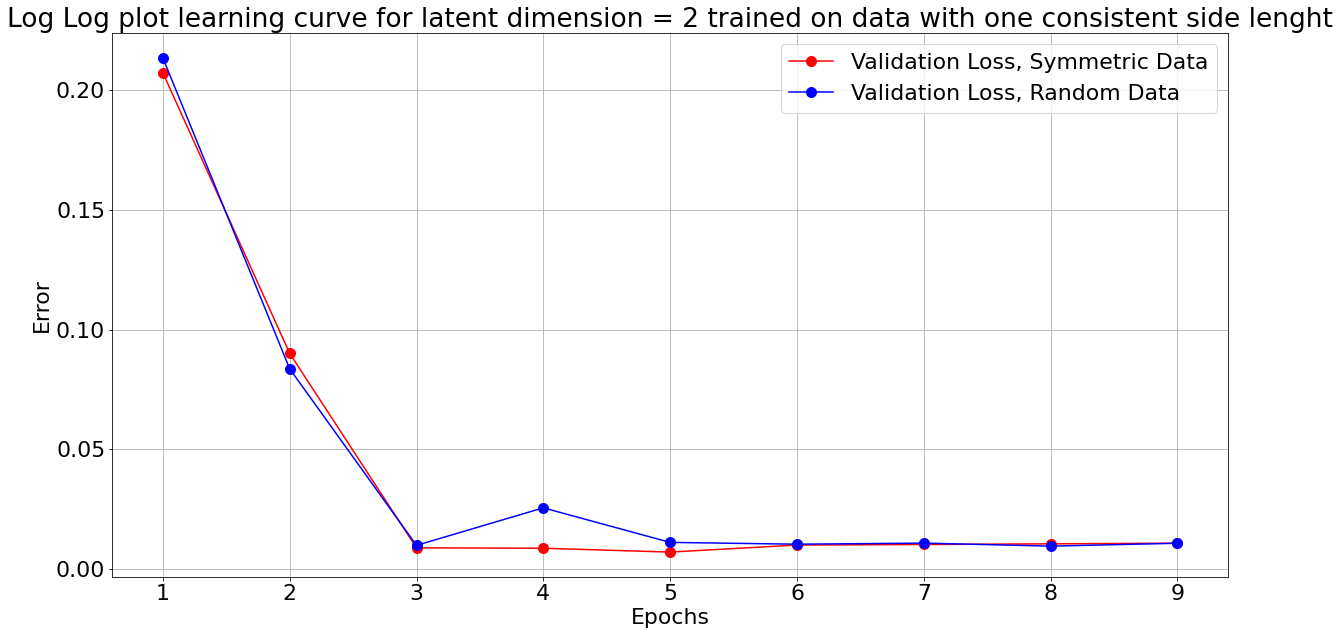

In [ ]:
# Plot Training Loss and Validation Loss

plt.figure(figsize=(20,10))
plt.plot(dims,losses_sym, 'ro-', markersize = 10, label='Validation Loss, Symmetric Data')
plt.plot(dims,losses, 'bo-',     markersize = 10, label='Validation Loss, Random Data')

plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Log Log plot learning curve for latent dimension = 2 trained on data with one consistent side lenght')
plt.legend()
plt.grid()

# Without permuation


### Generating Data

In [ ]:
def t():
  phi   = 2*np.pi*np.random.random()
  theta = np.pi*np.random.random()
  return np.array([np.sin(theta)*np.cos(phi),
                   np.sin(theta)*np.sin(phi),
                   np.cos(theta)])

In [ ]:
DATA_SIZE = 200000
side      =  .5    # Scaling for 
r_min     = 0.48   # Need a minimum as in nature the pole at r = 0 is non-phyiscal
l         = r_min+0.2

In [ ]:
# creating a dataset of triangles with a minimum side lenght r_min

side_lenghts = np.zeros( (DATA_SIZE, 3, ))
euc_data     = np.zeros( (DATA_SIZE, 9, ))

for i in range(DATA_SIZE):

  # Randomly selecting 2 points seperated by l
  v1= np.random.random( (3,) )
  TRUTH = True

  # Ensuring 2nd point is always in unit cube
  while TRUTH:
    v2 = v1 + l*t()
    if (np.all(0<v2)) and (np.all(v2<1)):
      TRUTH = False

  # ensuring minimum side lenght > r_min    
  col_vec = np.zeros(9)
  while( np.min(side_lens(col_vec)) <= r_min):
    v3      = np.random.random( (3,) )
    col_vec = np.concatenate((v1,v2,v3))
  
  # Randomly permute the side lenght 
  col_vec = np.reshape(col_vec, (3,3))
  perm    = [0,1,2]

  euc_data[i]   = np.concatenate( (col_vec[perm[0]],
                                   col_vec[perm[1]],
                                   col_vec[perm[2]]) ).flatten()
  
  side_lenghts[i]  = side_lens(euc_data[i]) 

In [ ]:
for i in range(3):
  vv1,vv2,vv3 = v1,v2,v3 = np.array_split(euc_data[i],3)

  Plot_2(v1,v2,v3,vv1,vv2,vv3)

In [ ]:
df = pd.DataFrame()
df['x1'] = euc_data[:,0];   df['x2'] = euc_data[:,3];   df['x3'] = euc_data[:,6];
df['y1'] = euc_data[:,1];   df['y2'] = euc_data[:,4];   df['y3'] = euc_data[:,7];
df['z1'] = euc_data[:,2];   df['z2'] = euc_data[:,5];   df['z3'] = euc_data[:,8];

df['L1'] = side_lenghts[:,0]; df['L2'] = side_lenghts[:,1]; df['L3'] = side_lenghts[:,2];

In [ ]:
# Euclidean data
x_data = np.array([df['x1'],df['y1'],df['z1'],
                   df['x2'],df['y2'],df['z2'],
                   df['x3'],df['y3'],df['z3'] ]).T
                   
# Side len data
x_data_sides  = np.array([df['L1'],
                          df['L2'],
                          df['L3']]).T

In [ ]:
# Splitting the array into validation, training, and test sets

# Euclidean training x-data
x_train,  x_val = train_test_split(x_data , test_size = 0.1  , shuffle = False)
x_train, x_test = train_test_split(x_train, test_size = 1./9., shuffle = False)

In [ ]:
x_data_sides

array([[0.68      , 0.77028365, 0.91701065],
       [0.68      , 0.85941145, 0.9223529 ],
       [0.68      , 0.76304753, 0.92328555],
       ...,
       [0.68      , 0.91825857, 1.00303823],
       [0.68      , 0.82113264, 0.71815322],
       [0.68      , 1.30645974, 0.97242148]])

## Building/training

In [ ]:
# Compile and Train 
AE_2 = get_model(2)
AE_2.compile(optimizer=keras.optimizers.Adam(amsgrad=True), loss=loss_function)
history_2 = AE_2.fit(x_train, x_train,     # For autoencoders input data = target data
                    epochs=1000,
                    validation_data=(x_val, x_val),
                    verbose = 2)

Epoch 1/1000
5000/5000 - 6s - loss: 0.0858 - val_loss: 0.0293
Epoch 2/1000
5000/5000 - 5s - loss: 0.0266 - val_loss: 0.0180
Epoch 3/1000
5000/5000 - 5s - loss: 0.0221 - val_loss: 0.0204
Epoch 4/1000
5000/5000 - 5s - loss: 0.0193 - val_loss: 0.0154
Epoch 5/1000
5000/5000 - 5s - loss: 0.0183 - val_loss: 0.0256
Epoch 6/1000
5000/5000 - 5s - loss: 0.0166 - val_loss: 0.0156
Epoch 7/1000
5000/5000 - 5s - loss: 0.0155 - val_loss: 0.0225
Epoch 8/1000
5000/5000 - 5s - loss: 0.0149 - val_loss: 0.0109
Epoch 9/1000
5000/5000 - 5s - loss: 0.0144 - val_loss: 0.0125
Epoch 10/1000
5000/5000 - 5s - loss: 0.0133 - val_loss: 0.0097
Epoch 11/1000
5000/5000 - 5s - loss: 0.0129 - val_loss: 0.0140
Epoch 12/1000
5000/5000 - 5s - loss: 0.0130 - val_loss: 0.0103
Epoch 13/1000
5000/5000 - 5s - loss: 0.0126 - val_loss: 0.0108
Epoch 14/1000
5000/5000 - 5s - loss: 0.0123 - val_loss: 0.0128
Epoch 15/1000
5000/5000 - 5s - loss: 0.0116 - val_loss: 0.0148
Epoch 16/1000
5000/5000 - 5s - loss: 0.0112 - val_loss: 0.0095
E

In [ ]:
AE_2.save("/content/drive/MyDrive/Project/Custom_loss/Symm_AE2_No_Perm")

In [ ]:
# Losses over a range of values of latent space size

losses   = []
dims     = range(1,7)
epochs   = 120

for dim in dims:
  print('\n\n\n DIM = %d'%dim,'\n\n\n')

  model = get_model(dim)
  model.compile(optimizer=keras.optimizers.Adam(amsgrad=True), loss=loss_function)
  model.fit(x_train, x_train,     # For autoencoders input data = target data
                         epochs=epochs,
                         validation_data=(x_val, x_val),
                         verbose = 0) 
  
  losses.append(model.evaluate(x = x_test, y = x_test))
losses




 DIM = 1 



Epoch 1/100
5000/5000 [==============================] - 7s 1ms/step - loss: 0.2536 - val_loss: 0.1643
Epoch 2/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1696 - val_loss: 0.1722
Epoch 3/100
5000/5000 [==============================] - 7s 1ms/step - loss: 0.1667 - val_loss: 0.1660
Epoch 4/100
5000/5000 [==============================] - 7s 1ms/step - loss: 0.1655 - val_loss: 0.1675
Epoch 5/100
5000/5000 [==============================] - 7s 1ms/step - loss: 0.1650 - val_loss: 0.1629
Epoch 6/100
5000/5000 [==============================] - 7s 1ms/step - loss: 0.1635 - val_loss: 0.1646
Epoch 7/100
5000/5000 [==============================] - 7s 1ms/step - loss: 0.1634 - val_loss: 0.1650
Epoch 8/100
5000/5000 [==============================] - 7s 1ms/step - loss: 0.1626 - val_loss: 0.1627
Epoch 9/100
5000/5000 [==============================] - 7s 1ms/step - loss: 0.1627 - val_loss: 0.1598
Epoch 10/100
5000/5000 [==============================] -

[0.15650978684425354,
 0.005110298283398151,
 0.005919668357819319,
 0.0061014085076749325,
 0.007097426801919937,
 0.010250953026115894]

## Comparison of all types


In [33]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
loss_rnd = np.array([0.4100509285926819,
 0.18451963365077972,
 0.010563643649220467,
 0.009684955701231956,
 0.010624747723340988,
 0.006630274932831526])
loss_perm = [0.20713117718696594,
 0.09006083011627197,
 0.008942085318267345,
 0.008771459572017193,
 0.007165366318076849,
 0.010100094601511955,
 0.010335803963243961,
 0.010611397214233875,
 0.010879658162593842]
loss_no_perm = [0.15650978684425354,
                0.005110298283398151,
                0.005919668357819319,
                0.0061014085076749325,
                0.007097426801919937,
                0.010250953026115894]

sc = scaler
dims = np.arange(6)+1

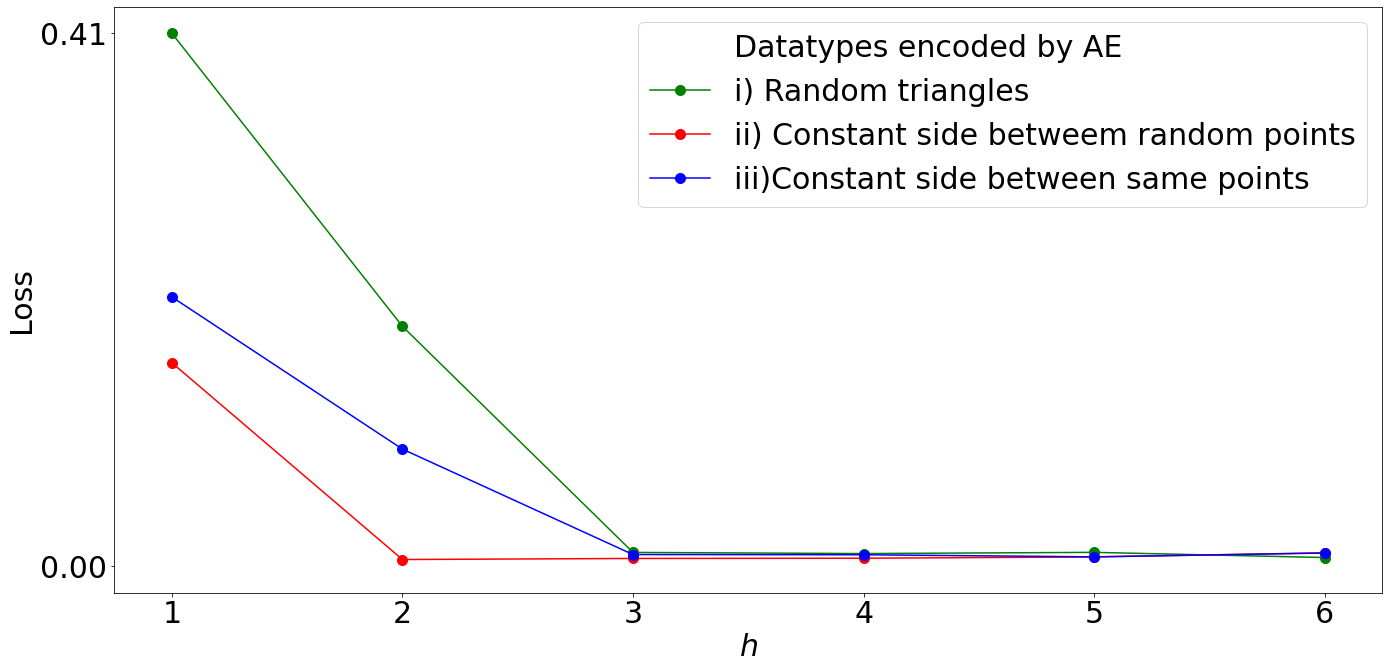

In [37]:
# Plot Training Loss and Validation Loss
matplotlib.rcParams.update({'font.size': 30})

plt.figure(figsize=(20,10))
plt.plot(2,0, 'white', markersize = .2,   label='Datatypes encoded by AE')
plt.plot(dims,loss_rnd[:6], 'go-', markersize = 10,   label='i) Random triangles')
plt.plot(dims,loss_no_perm, 'ro-', markersize = 10,   label='ii) Constant side betweem random points')
plt.plot(dims,loss_perm[:6],'bo-', markersize = 10,   label='iii)Constant side between same points')
plt.yticks([0,np.max(loss_rnd)])
plt.xlabel('$h$')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Symmester 2/Final year project/Writeup/Diagrams/loss_vs_lat_sym', transparent=True, bbox_inches = 'tight')